In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import os
import random
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob

from google.colab import output



In [2]:
!nvidia-smi -L


GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-0d6f57c0-6d94-2e32-6fdf-4579d3b705b6)


In [3]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

! pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

CUDA version: 11.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [4]:


%cd /content/

!git clone https://github.com/openai/CLIP.git


%cd /content/CLIP/

!pip install ftfy

import clip


import numpy as np
# Load the model
perceptor, preprocess = clip.load('ViT-B/32')


/content
fatal: destination path 'CLIP' already exists and is not an empty directory.
/content/CLIP


In [5]:
im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape

tx = clip.tokenize("Hope for a brighter future of children")

In [6]:
def displ(img, pre_scaled=True):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  if not pre_scaled:
    img = scale(img, 48*4, 32*4)
  imageio.imwrite(str(3) + '.png', np.array(img))
  return display.Image(str(3)+'.png')

def card_padded(im, to_pad=3):
  return np.pad(np.pad(np.pad(im, [[1,1], [1,1], [0,0]],constant_values=0), [[2,2], [2,2], [0,0]],constant_values=1),
            [[to_pad,to_pad], [to_pad,to_pad], [0,0]],constant_values=0)


In [7]:

import torch.nn as nn

class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=True, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True)
        output = self.net(coords.cuda())
        return output.view(1, sideX, sideY, 3).permute(0, 3, 1, 2)#.sigmoid_()

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations


def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid


model = Siren(2, 256, 16, 3).cuda()
LLL = []
eps = 0

optimizer = torch.optim.Adam(model.parameters(), .00001)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


tensor(-21.1875, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


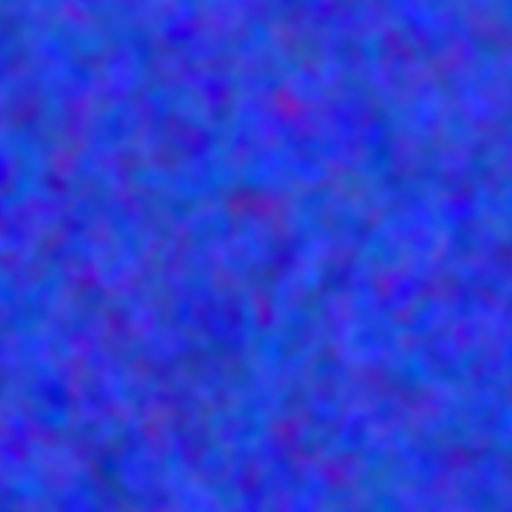

tensor(-41.5625, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


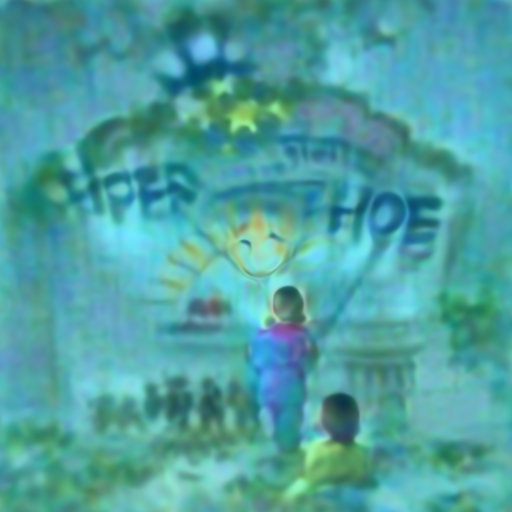

tensor(-45.6562, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


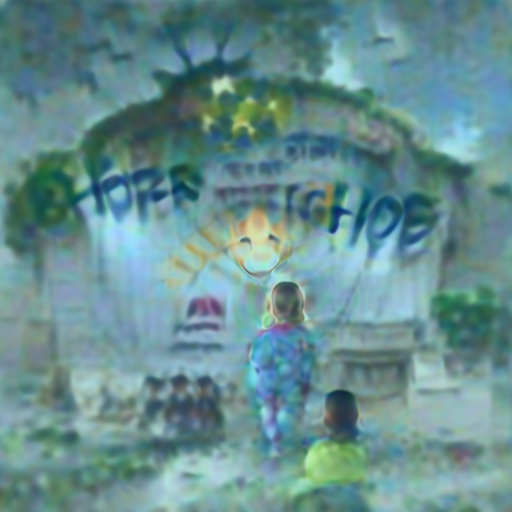

tensor(-46.8750, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


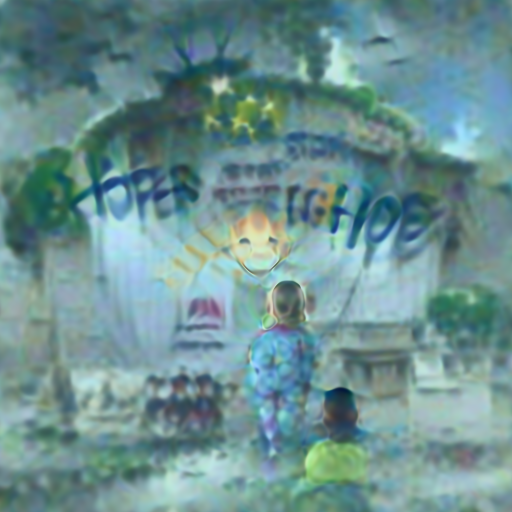

tensor(-47.3750, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


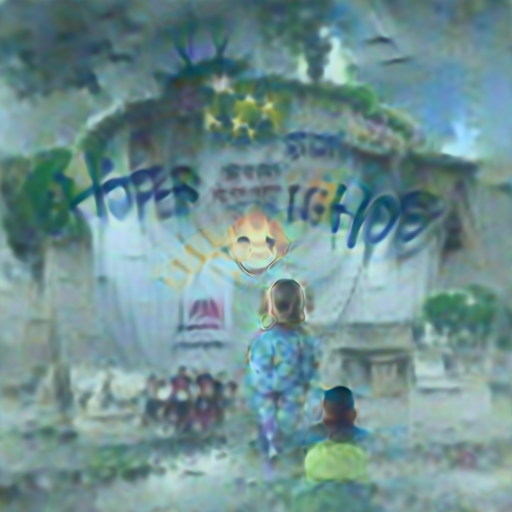

tensor(-47.3750, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


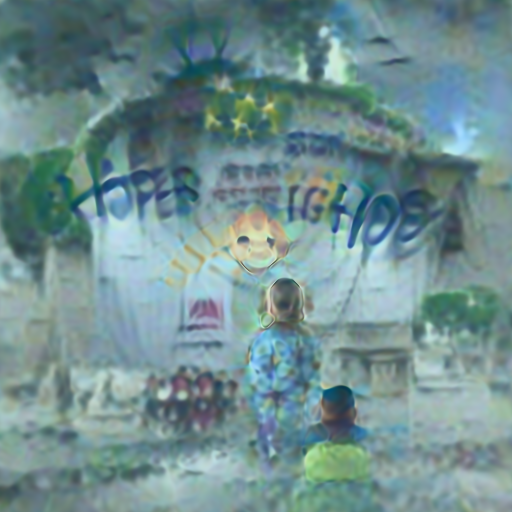

In [ ]:
def checkin(loss):
  print(loss)
  with torch.no_grad():
    al = nom(model(get_mgrid(sideX)).cpu()).numpy()
  for allls in al:
    displ(allls)
    display.display(display.Image(str(3)+'.png'))
    print('\n')
  output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')


def ascend_txt():
  out = model(get_mgrid(sideX))

  cutn = 64
  p_s = []
  for ch in range(cutn):
    size = torch.randint(int(.5*sideX), int(.98*sideX), ())
    offsetx = torch.randint(0, sideX - size, ())
    offsety = torch.randint(0, sideX - size, ())
    apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='bilinear')
    p_s.append(nom(apper))
  into = torch.cat(p_s, 0)


  
  iii = perceptor.encode_image(into)
  t = perceptor.encode_text(tx.cuda())
  return -100*torch.cosine_similarity(t, iii, dim=-1).mean()

def train(epoch, i):
  loss = ascend_txt()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  

  
  
  if itt % 150 == 0:
    checkin(loss)

nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))


itt = 0
for epochs in range(10000):
  for i in range(1000):
    train(eps, i)
    itt+=1
  eps+=1
